# Imports

In [1]:
import pandas as pd
from os.path import join
from documents.Corpus import Corpus
from citations.CitationClassifier import CitationClassifier
from config import *
import numpy as np
import json
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


csv_path = '/Users/Alex/Library/CloudStorage/GoogleDrive-alexjfogelson@gmail.com/My Drive/FutureTech/workspace/urop_task2_markdown/task2_with_paperIds.csv'
markdown_path = '/Users/Alex/Library/CloudStorage/GoogleDrive-alexjfogelson@gmail.com/My Drive/FutureTech/workspace/true_urop_task2_markdown/'


# Retrieve UROP dataframe

In [2]:
urop_og_df = pd.read_csv(csv_path)
mapping = {'citation.intent1': 'classification', 'model.paperId': 'modelId', 'citation.paperId':'paperId'}
urop_og_df = urop_og_df.rename(columns = mapping)[mapping.values()]
urop_og_df['classification'] = urop_og_df['classification'].apply(str.lower)
print(f"Found {len(urop_og_df)} total rows in UROP CSV dataset.")

valid_categories = {'background', 'differences', 'extends','future work', 'motivation', 'similarities', 'uses'}
urop_df = urop_og_df[urop_og_df['classification'].apply(lambda s: s in valid_categories)].copy() 
print(f"Found {len(urop_df)} valid rows in dataset. Dropped {len(urop_og_df) - len(urop_df)} rows for invalid classification.")

order_class_values = ['extends', 'uses', 'differences', 'similarities', 'future work', 'motivation', 'background']
urop_df['classification_order'] = urop_df['classification'].apply(order_class_values.index)

urop_foundation_models = set(urop_df['modelId'].to_list())
print(f"Found {len(urop_foundation_models)} distinct foundation models referenced in the dataset.")

urop_df[['classification', 'modelId', 'paperId']]

Found 703 total rows in UROP CSV dataset.
Found 696 valid rows in dataset. Dropped 7 rows for invalid classification.
Found 328 distinct foundation models referenced in the dataset.


,classification,modelId,paperId
0,uses,3647d6d0f151dc05626449ee09cc7bce55be497e,e83012a4c4041a170d7dbe4fe48113c32f519701
1,background,ebb85974e06c4879b451fdfcb4f472a09471935b,f2a29214d169dd032fb13be44e9b11e74710472f
2,background,24badbe57bbe956ea38afd4b02a214da1bc57a6c,6c821635f65026c782ac37eceff97949a9f231de
3,background,a538b05ebb01a40323997629e171c91aa28b8e2f,d31b0f55bbe44caf586e3b0e8424129ea8f068cd
4,background,319b84be7a843250bc81d7086f79a4126d550277,a26623d52d24e03044a158cddad931ec5ab7304c
...,...,...,...
698,background,0060745e006c5f14ec326904119dca19c6545e51,cd241c2a4228bc7f4d5d0fc2abc941f73d8558ac
699,background,0b544dfe355a5070b60986319a3f51fb45d1348e,d5af97ead51b1c937d4008ec814798ee66116225
700,uses,7698498dcb14db063154f4c955fc041114d1960d,81e20d4641b6261c23184f98fd1585d64c85eb40
701,background,62516303058a1322450b58e4cd778ab873b5e531,28dca13befd068dfa1cf498bba45020cf22ec16f


# Generate and Analyze Corpus

In [3]:
classifier = CitationClassifier(CITATION_MODEL_PATH)
corpus = Corpus(markdown_path, 
                    extensions = ['mmd'])

with open(FOUNDATION_MODELS_PATH, 'r') as f:
    foundational_models_json = json.load(f)
    keys_, titles_, ids_ = list(zip(*[(key, data['title'].replace('\\infty', '∞'), data['paperId']) for key, data in foundational_models_json.items()]))
    keys_, titles_, ids_ = list(keys_), list(titles_), list(ids_)

foundation_model_filter = [id in urop_foundation_models for id in ids_]
keys, titles = np.array(keys_)[foundation_model_filter].tolist(), np.array(titles_)[foundation_model_filter].tolist()

corpus.findAllPaperRefsAllTitles(titles = titles, keys = keys, classifier = classifier)

textualRefs = corpus.getAllTextualReferences(as_dict=True)

100%|██████████| 350/350 [00:59<00:00,  5.87it/s]


# Generate Dataframe

In [4]:
model_df = pd.DataFrame(textualRefs)
model_df['paperId'] = model_df['paperId'].apply(lambda s: s.replace('.mmd',''))
model_df['modelId'] = model_df['FM_key'].apply(lambda s: ids_[keys_.index(s)])

order_class_values = ['extends', 'uses', 'differences', 'similarities', 'future_work', 'motivation', 'background', 'usetobackground']
#order_class_values = ['method', 'result', 'background', 'NONE']
model_df['classification_order'] = model_df['classification'].apply(order_class_values.index)

model_df = model_df[model_df['classification'] != 'NONE']

print(f"Model dataset found")
model_df[['classification', 'paperId', 'modelId']]


Model dataset found


,classification,paperId,modelId
0,background,dabe1965c03238e0c5f1718eeb4c2a834efafaba,b3848d32f7294ec708627897833c4097eb4d8778
1,background,dabe1965c03238e0c5f1718eeb4c2a834efafaba,b3848d32f7294ec708627897833c4097eb4d8778
2,uses,486b699576b4219168c9be0841556eaabc620b1a,1518039b5001f1836565215eb047526b3ac7f462
3,uses,486b699576b4219168c9be0841556eaabc620b1a,9405cc0d6169988371b2755e573cc28650d14dfe
4,uses,486b699576b4219168c9be0841556eaabc620b1a,395de0bd3837fdf4b4b5e5f04835bcc69c279481
...,...,...,...
1931,background,5fc1a1f79ea4d1a1c6e8da1a40ae08022a6d7308,c2f91f35df893714418cc29096083dce0b441229
1932,background,5fc1a1f79ea4d1a1c6e8da1a40ae08022a6d7308,c2f91f35df893714418cc29096083dce0b441229
1933,uses,8022d479aac0efead15dcf7036aac8845c99d51b,54020e5fe48ebb250f27d744e20a63cac2988a84
1934,uses,8022d479aac0efead15dcf7036aac8845c99d51b,54020e5fe48ebb250f27d744e20a63cac2988a84


# Take best classification amongst all sentences

In [5]:
urop_df['classification_ranking'] = urop_df.groupby(['modelId', 'paperId'])['classification_order'].rank(method='min')
model_df['classification_ranking'] = model_df.groupby(['modelId', 'paperId'])['classification_order'].rank(method='min')

relevant_columns = ['classification', 'paperId', 'modelId']
urop_classification_counts = (urop_df[urop_df['classification_ranking'] == 1])[relevant_columns].reset_index()
model_classification_counts = (model_df[model_df['classification_ranking'] == 1])[relevant_columns + ['labels']].reset_index()

# Join dataframes

In [6]:
all_classifications = urop_classification_counts.merge(model_classification_counts, on = ['modelId', 'paperId'], how='inner', suffixes=('_true','_pred'))

usage_rows = all_classifications[all_classifications['classification_pred'].apply(lambda s: s in ['usetobackground'])]

print(f"Printing out rows which we switched from use to background based on section labels.")
usage_rows

Printing out rows which we switched from use to background based on section labels.


,index_true,classification_true,paperId,modelId,index_pred,classification_pred,labels


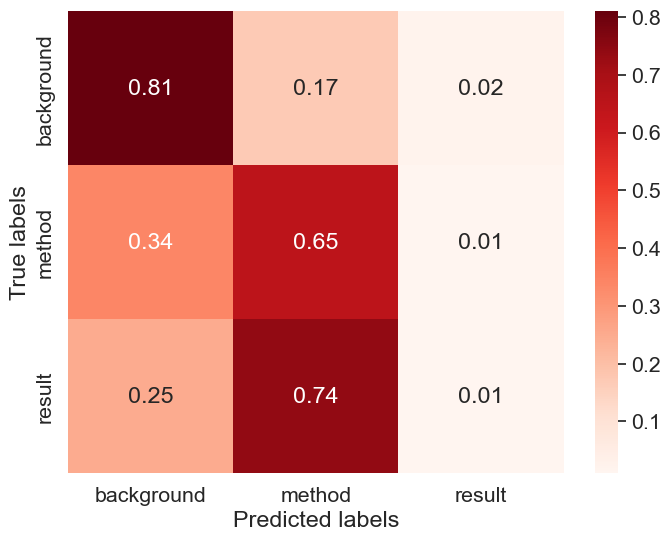

In [7]:
true_labels = all_classifications['classification_true'].to_list()
predicted_labels = all_classifications['classification_pred'].to_list()

mapping = lambda s: {
            'differences': 'result',
            'similarities': 'result',
            'motivation': 'background',
            'extends':'method',
            'uses': 'method',
            'usetobackground': 'method',
            'future_work':'background',
            'future work':'background',
            'background': 'background'}.get(s) or s


true_labels = list(map(mapping, true_labels))
predicted_labels = list(map(mapping, predicted_labels))


mask = (np.array(true_labels) == 'results') | (np.array(predicted_labels) == 'results')
true_labels = list(np.array(true_labels)[~mask])
predicted_labels = list(np.array(predicted_labels)[~mask])


cm = confusion_matrix(true_labels, predicted_labels, normalize = 'true').round(2)
perm = list(range(len(cm)))


cm = cm[perm][:, perm]
ticks = np.unique(predicted_labels + true_labels)[perm]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.4)  # Adjust font size
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', xticklabels=ticks, yticklabels=ticks)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

title = '' #input()
plt.title(title)
plt.show()

# Check Markdown Counts

In [8]:
from os import listdir

csv_path = '/Users/Alex/Library/CloudStorage/GoogleDrive-alexjfogelson@gmail.com/My Drive/FutureTech/workspace/urop_task2_markdown/task2_with_paperIds.csv'
markdown_path = '/Users/Alex/Library/CloudStorage/GoogleDrive-alexjfogelson@gmail.com/My Drive/FutureTech/workspace/true_urop_task2_markdown/'

urop = pd.read_csv(csv_path)


urop_papers = set(urop['citation.paperId'].to_list())
folder_papers = set(map(lambda s: s.replace('.mmd',''), listdir(markdown_path)))

print(len(urop_papers.intersection(folder_papers)))
print(len(urop_papers))
print(len(folder_papers))

assert(len(folder_papers) == len(urop_papers.intersection(folder_papers)))

365
506
365
